
---
### What is CCT, and why do we use it?

---

**CCT** stands for **Compact Convolutional Transformer**. It is a powerful architecture used in **Computer Vision** problems because it combines the best features of **transformers** and **convolutional neural networks (CNNs)**.

---

##### Key Features of CCT:
- In **Vision Transformer (ViT)**, patches are required. But in **CCT**, the model starts by using **convolutional layers**.
  - These layers extract important features from images, such as **edges** and **textures**.
  - This helps in representing images better and ensures that the model can capture **local patterns** from the image.
  
- After the convolutional layers, **pooling** is required to reshape the images.
  - This reshaped output works as a sequence for the **transformer model**.
  
- **Positional embedding** is usually needed for patches in **ViT**, but in **CCT**, positional embedding is optional.
  - This is because the reshaped image already contains enough information for the transformer encoder.
  
---

##### Transformer Encoder in CCT:

- The **Transformer Encoder** processes the sequence of image tokens (small pieces of the image) and learns how they relate to each other.
- It captures both **local** and **global** patterns in the image.
- The **self-attention** mechanism allows each token to look at every other token in the image and identify the important relationships.
- This helps the model understand how different parts of the image, such as edges and textures, interact.
  
---

##### Sequence Pooling in CCT:

- After the transformer encoder processes the tokens, **Sequence Pooling** gathers information from all tokens and creates a **single, condensed representation** of the entire image.
- The pooled representation is an average (or sum) of all tokens, which is used for classification.
- This step effectively summarizes the whole image into **one vector**, enabling the model to classify the image without needing to focus on individual patches anymore.

---

##### MLP Head in CCT:

- The **MLP Head** (Multilayer Perceptron) is the final part of the model.
  - It takes the pooled representation from sequence pooling and predicts the class of the image (e.g., t-shirt, shoe, etc.).
  - The MLP Head is a simple, fully connected neural network made up of one or more layers of neurons.
  - These neurons process the pooled image representation and output the final prediction, like a 90% chance that the image is a "t-shirt".
  
---

##### Summary:
- **CCT** is particularly effective for **small datasets**, as it uses convolution to extract local features and combines it with transformers to understand **global relationships** within the image.
- This gives it a strong ability to **recognize complex visual patterns**.
- **ViT**, on the other hand, works well with **large datasets**.


![alt text](model_sym.png)

![alt text](comparison.png)

##### Now that we got a grip on CCT basics, we are going to implement CCT on the FashionMnist dataset.

- At First we will import the necessary libraries and load the dataset


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
from torchviz import make_dot
from torchview import draw_graph
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
# Load the FashionMNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

In [3]:
#Augmentation
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(28, padding=4),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

In [4]:
# Load the FashionMNIST dataset 
#full_train_dataset = datasets.FashionMNIST(root='./data', train=True,transform=transform_train, download=True)

In [5]:
# Split into training (90%) and validation (10%)
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [6]:
# Load the datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

In [7]:
# Load the test dataset (which is kept aside for evaluation only)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Sample images from the training set:


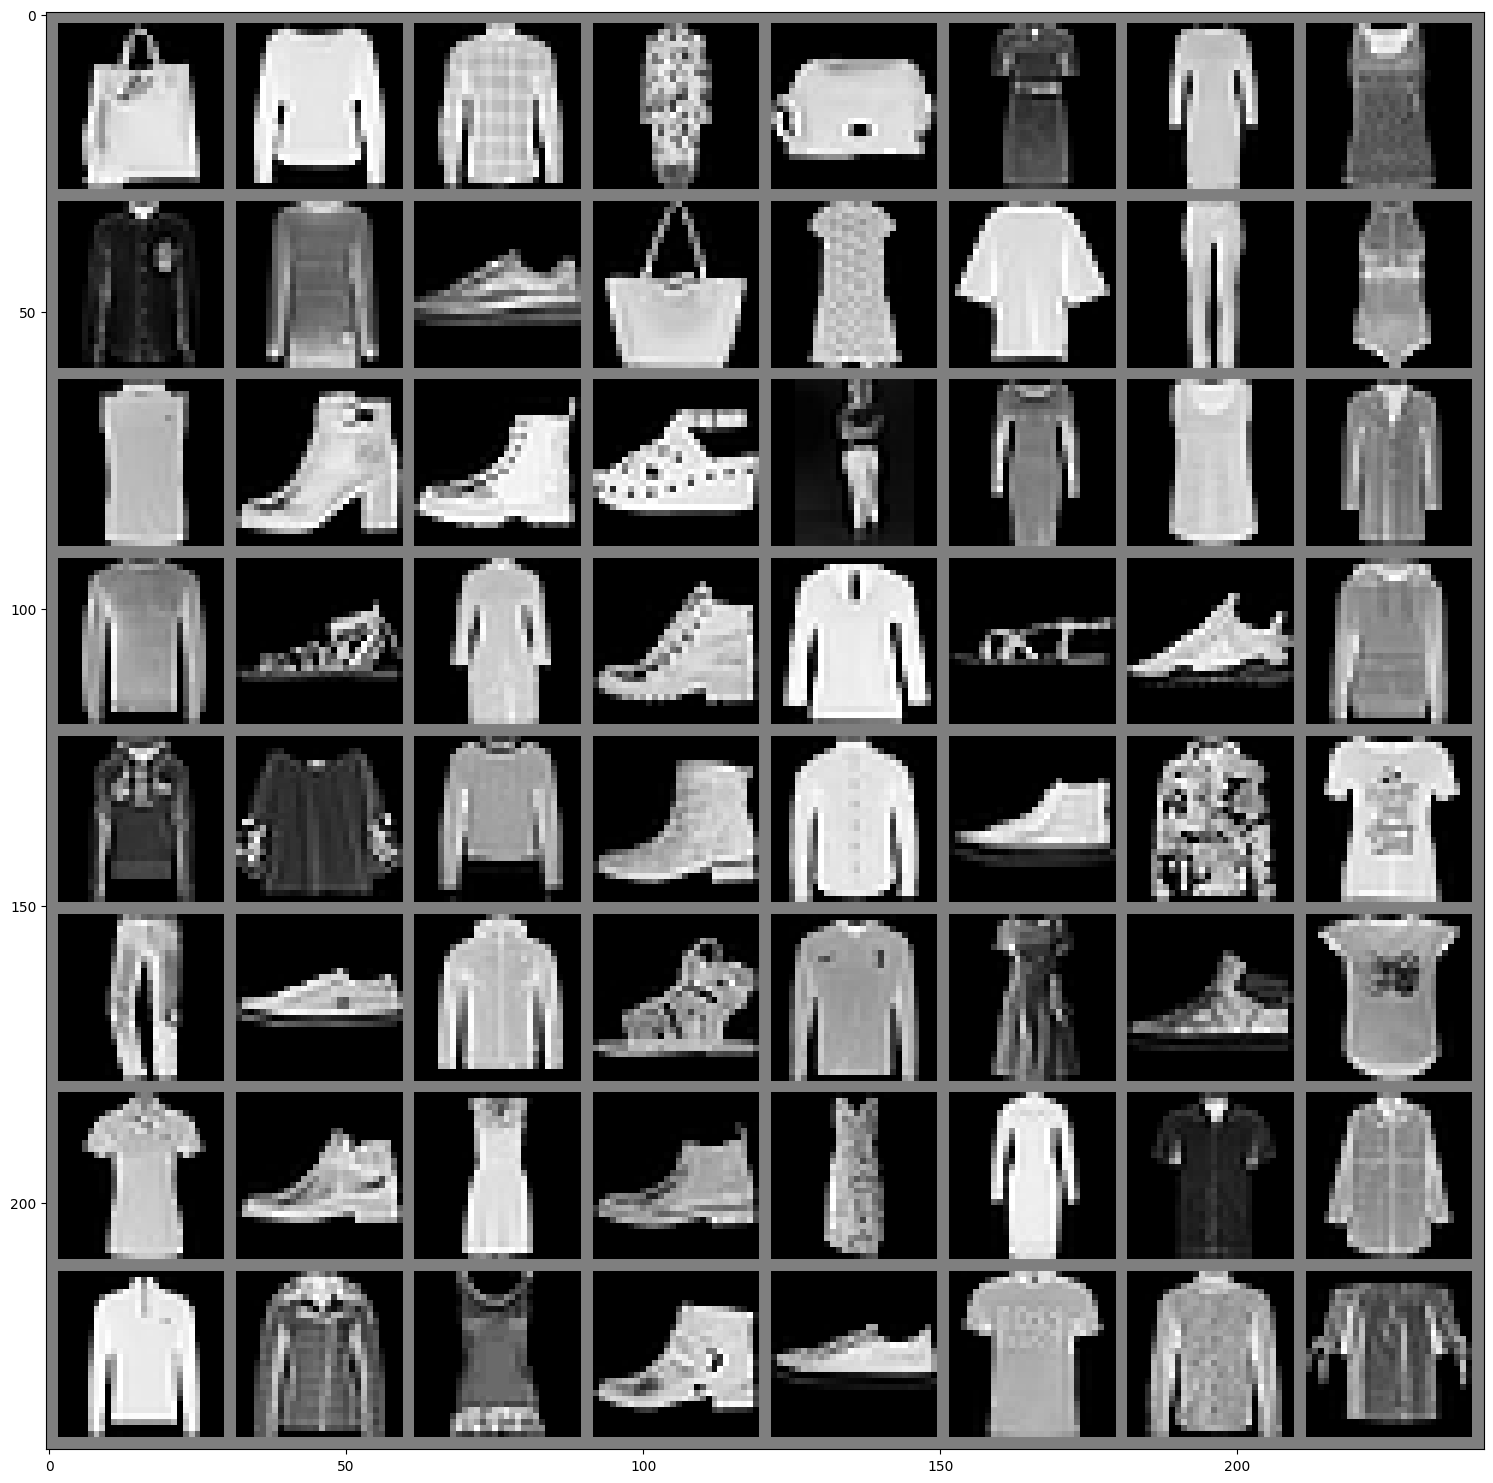

In [8]:
# Get a batch of training data
trainiterator = iter(train_loader)
images, label = trainiterator.next()

# Helper function to display a batch of images

def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

# Show images
print("Sample images from the training set:")
plt.figure(figsize=(15,15))
imshow(make_grid(images))

In [9]:
# Print the shape of the training, validation, and test sets
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

# Print shape of a single batch of data
print(f"Shape of images batch (training set): {images.shape}")
print(f"Shape of labels batch (training set): {label.shape}")

Training set size: 54000 samples
Validation set size: 6000 samples
Test set size: 10000 samples
Shape of images batch (training set): torch.Size([64, 1, 28, 28])
Shape of labels batch (training set): torch.Size([64])



---

### Detailed Explanation of the **ImprovedTransformerLayer**:

---

The **ImprovedTransformerLayer** consists of key building blocks that enhance the transformer architecture with **multi-head attention**, **feedforward layers**, **layer normalization**, and **residual connections**. These components work together to ensure the model can effectively capture relationships within the data while maintaining stability during training. Below is a breakdown of how each component functions:

##### 1. **Multi-head Attention** (`self.attention`):
- **What it does**: 
  - The **multi-head attention mechanism** allows the model to focus on different parts of the input sequence simultaneously. This is crucial for understanding relationships between tokens (image patches, words, etc.) across the entire sequence.
  - **Self-attention** enables each token to attend to all other tokens in the sequence, learning which parts of the sequence are most important for each token. This gives the model the ability to capture both local and global dependencies.

- **Key Parameters**:
  - **`embedding_dim`**: This represents the dimensionality of each token's embedding. It defines the size of the vector that represents each token after the convolutional layers.
  - **`num_heads`**: Multi-head attention splits the attention mechanism into multiple "heads" (parallel attention computations). Each head learns different relationships between tokens, allowing the model to focus on multiple aspects of the data simultaneously. For example, one head might focus on nearby tokens, while another looks at more distant ones.
  - **Dropout in Attention**: In this implementation, dropout is applied **within the attention mechanism** itself (controlled by `attention_dropout`). This regularization technique prevents overfitting and ensures that the model does not rely too heavily on any specific attention heads.

- **How it works**:
  - The input tensor `x` is passed through the multi-head attention layer, where each token in the sequence can "attend" to every other token. This is done using three matrices: **query**, **key**, and **value**, all derived from the input itself in self-attention.
  - The attention mechanism computes a weighted sum of the values, where the weights are determined by the query-key pairs.
  - The multi-head aspect enables multiple independent attention heads to capture diverse patterns in the data.
  
---

##### 2. **Residual Connections** and **Layer Normalization**:

- **Residual Connections**:
  - **What it does**: 
    - A **residual connection** adds the original input `x` back to the output of the attention or feed-forward layers. This direct connection helps maintain the original information while also incorporating the new transformations. 
    - Residual connections are crucial in deep models like transformers because they allow **gradients to flow more easily** during backpropagation, reducing the risk of vanishing gradients.
  - **Why it's important**:
    - As models get deeper, there is a risk of information loss or degradation through successive layers. Residual connections help mitigate this issue by ensuring that the original information is preserved.

- **Layer Normalization**:
  - **What it does**:
    - **Layer normalization** is applied after the attention and feedforward operations to stabilize the learning process. It normalizes the input so that it has a mean of 0 and a variance of 1, helping to maintain the stability of activations.
  - **Why it's important**:
    - Without normalization, the model’s activations could become too large or too small, which can slow down learning or cause instability. Normalization ensures that the data flows through the network in a more controlled and stable way, helping the model converge faster and reducing the risk of vanishing/exploding gradients.
  - **When it’s applied**: 
    - Layer normalization is applied **after** the residual connection, ensuring that the combined input and attention output are normalized before passing to the next layer.
  
---

##### 3. **Feedforward Network (FFN)** (`self.ff`):

- **What it does**:
  - The **feedforward network (FFN)** is a two-layer neural network applied independently to each token in the sequence. It helps the model learn more complex, non-linear representations after the attention mechanism.
  
- **How it works**:
  - The FFN consists of:
    1. **Linear Transformation** (`nn.Linear(embedding_dim, ff_dim)`): The first linear layer projects the input (of size `embedding_dim`) to a higher-dimensional space (`ff_dim`), allowing the model to capture more abstract and complex representations of the data.
    2. **ReLU Activation** (`nn.ReLU()`): The ReLU activation introduces non-linearity, allowing the model to learn more complex relationships.
    3. **Second Linear Transformation** (`nn.Linear(ff_dim, embedding_dim)`): The second linear layer projects the data back to the original embedding dimension (`embedding_dim`), ensuring that the output can be processed further or used for residual connections.

- **Why it's important**:
  - The attention mechanism captures relationships between tokens, but the FFN helps the model capture higher-level patterns and enriches the representation of the data.
  - By applying the FFN to each token independently, the model can learn complex transformations for each token in the sequence.
  
---

##### Summary of Improvements in the Transformer Layer:

- **Multi-head attention** allows the model to focus on multiple aspects of the sequence simultaneously, capturing both local and global relationships between tokens.
- **Attention Dropout** (newly added) regularizes the attention mechanism to prevent overfitting and improve generalization.
- **Residual connections** and **layer normalization** help maintain stability, allowing the model to train effectively by keeping gradients flowing and preventing the loss of information.
- The **feedforward network** further transforms the token representations, allowing for more complex pattern recognition in the data.

The **ImprovedTransformerLayer** combines these components to create a powerful, robust, and scalable model block that can be used in deep models for processing sequences such as images (after convolutional tokenization) or text.

---

This revised explanation reflects the updated transformer layer with dropout applied specifically within the multi-head attention mechanism.

##### Summary of Improvements in the Transformer Layer:

- **Multi-head attention** allows the model to focus on multiple aspects of the sequence simultaneously, capturing both local and global relationships between tokens.
- **Residual connections** and **layer normalization** help maintain stability, allowing the model to train effectively by keeping gradients flowing and preventing the loss of information.
- The **feedforward network** further transforms the token representations, allowing for more complex pattern recognition in the data.
- **Dropout** is applied throughout the layer to ensure the model is not overfitting, improving generalization to unseen data.

The **ImprovedTransformerLayer** combines these components to create a powerful, robust, and scalable model block that can be used in deep models for processing sequences such as images (after convolutional tokenization) or text.

---

In [10]:
# Improved Transformer Layer without Dropout
class ImprovedTransformerLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, attention_dropout=0.2):
        super(ImprovedTransformerLayer, self).__init__()
        # Multi-head Attention Layer with Layer Normalization
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads, dropout=attention_dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        
        # Feedforward Neural Network without Dropout
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embedding_dim),
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

    def forward(self, x):
        # Multi-head Self Attention
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output  # Residual connection
        x = self.norm1(x)  # Normalize after attention

        # Feedforward Network
        ff_output = self.ff(x)
        x = x + ff_output  # Residual connection
        x = self.norm2(x)  # Normalize after feedforward

        return x


---

### Now we will build the **Compact Convolutional Transformer (CCT)** model

---

##### 1. **Convolutional Tokenization**:
  - The purpose of convolutional tokenization is to extract local features from the input image. It transforms the input images of size 28x28 into meaningful feature maps that can be processed by the transformer.
  - **In the Image**: The CCT architecture starts with a **Convolutional Tokenization** block, which consists of **5 convolutional layers** with **Batch Normalization** and **Dropout** added after each `ReLU` activation. This helps improve generalization and prevent overfitting in the convolutional feature extraction phase.
  - **In the Code**: 
    ```python
    self.conv_layers = nn.Sequential(
        nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),  # Added BatchNorm
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),  # Added BatchNorm
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),  # Added BatchNorm
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),  # Added BatchNorm
        nn.ReLU(),
        nn.Dropout(dropout),  # Dropout added
        nn.Conv2d(128, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=128
        nn.BatchNorm2d(embedding_dim),  # Added BatchNorm
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
    )
    ```
  - **Explanation**: The model uses **five convolutional layers** (`nn.Conv2d`) to extract local features from the input image. Each convolutional layer has a **ReLU activation**, followed by **Batch Normalization** to stabilize and normalize the activations and **Dropout** to regularize and prevent overfitting during training. The final convolutional layer reduces the feature maps to `embedding_dim=128`, and the output is downsampled using a **MaxPool2d** layer to shrink the spatial dimensions from 28x28 to 14x14.

---

##### 2. **Reshape**:
  - **In the Image**: After the convolutional layers, the output feature maps are reshaped into a sequence that can be processed by the transformer.
  - **In the Code**: 
    ```python
    x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
    x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]
    ```
  - **Explanation**: The feature maps output by the convolutional layers (with shape `[batch_size, embedding_dim, height, width]`) are flattened into a sequence of **196 tokens** (`14 * 14 = 196`), with each token having a size of `embedding_dim=128`. This prepares the data for processing by the transformer encoder.

---

##### 3. **Positional Embedding** (Optional):
  - **What it does**: Helps the transformer encoder understand the position of each token (patch).
  - **In the Image**: The architecture uses **optional positional embeddings**, which provide positional information about each token in the sequence.
  - **In the Code**:
    ```python
    self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))
    x += self.pos_embedding
    ```
  - **Explanation**: A learnable positional embedding (`self.pos_embedding`) is added to the token sequence. This ensures that the transformer has positional awareness, allowing it to understand where each patch comes from in the image. This is optional but can improve the model's ability to capture spatial relationships.

---

##### 4. **Transformer Encoder**:
  - **What it does**: The transformer encoder models global relationships across the image by processing the token sequence using **multi-head attention** and **feedforward networks**.
  - **In the Image**: The CCT architecture uses **multiple transformer encoder layers** to capture relationships between different parts (tokens) of the image.
  - **In the Code**:
    ```python
    self.transformer_layers = nn.ModuleList([
        ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, attention_dropout) 
        for _ in range(num_transformer_layers)
    ])
    for layer in self.transformer_layers:
        x = layer(x)
    ```
  - **Explanation**: The model applies **`num_transformer_layers`** transformer layers, each consisting of **multi-head attention** and **feedforward networks (FFN)**. This helps the model capture both local and global relationships within the image. In this version, **attention dropout** is applied to the attention mechanism to improve generalization.

---

### Explanation of the **ImprovedTransformerLayer**:

- **Multi-head Attention** (`self.attention`):
  - The **multi-head attention** mechanism allows the model to focus on different parts of the image simultaneously. This enables the model to capture relationships between various tokens (patches) in the image. 
  - **`embedding_dim`** specifies the size of each token embedding, and **`num_heads`** controls how many parallel attention mechanisms are used to capture diverse relationships. **Attention dropout** helps prevent overfitting in the attention mechanism.

- **Residual Connections** and **Layer Normalization**:
  - **Residual connections** add the original input back to the output of the attention and feedforward layers. This stabilizes training by ensuring gradient flow and reducing the risk of vanishing gradients.
  - **Layer normalization** normalizes the output after each operation, ensuring that activations remain stable and preventing the model from becoming unstable during training.

- **Feedforward Network** (`self.ff`):
  - The **feedforward network** consists of two linear transformations with a ReLU activation in between. It projects the input to a higher-dimensional space and back, helping the model learn more complex representations of the data.

---

##### 5. **Sequence Pooling**:
  - **What it does**: Combines the output of the transformer encoder for classification.
  - **In the Image**: The **sequence pooling** layer summarizes the information from the entire sequence (output from the transformer encoder) into a single representation.
  - **In the Code**:
    ```python
    if self.pooling == 'sequence':
      x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
    ```
  - **Explanation**: In sequence pooling, the outputs of the transformer are averaged across all tokens (`x.mean(dim=1)`). This combined representation of the entire image is then passed to the final classification layer.

---

##### 6. **Linear Layer**:
  - **In the Image**: The final block of the architecture is a **linear layer** that generates the classification output.
  - **In the Code**:
    ```python
    self.fc = nn.Linear(embedding_dim, num_classes)
    x = self.fc(x)
    ```
  - **Explanation**: The model’s final prediction is generated by a fully connected layer (`nn.Linear`), which takes the pooled output from the transformer encoder and maps it to the output classes (10 for FashionMNIST).

---

##### 7. **Classification**:
  - **In the Code**:
    ```python
    x = self.fc(x)
    ```
  - **Explanation**: The fully connected layer produces the final classification by mapping the learned features to the output classes. For FashionMNIST, this corresponds to predicting one of 10 classes (e.g., "t-shirt," "shoe," etc.).

---

### Key Changes:
- **Batch Normalization added**: Batch normalization (`BatchNorm2d`) is applied after each convolutional layer to stabilize and normalize activations, improving the model’s convergence and overall performance.
- **Dropout added in convolutional layers**: Dropout is applied after each **ReLU** activation in the convolutional layers to regularize the feature extraction process and prevent overfitting.
- **Attention Dropout added**: In the **ImprovedTransformerLayer**, dropout is applied within the attention mechanism itself to reduce overfitting and improve generalization.

This explanation covers the **Compact Convolutional Transformer (CCT)** model with **Batch Normalization**, **Dropout**, and **multi-head attention**. It clarifies how the convolutional layers extract features, the transformer encoder captures global relationships, and the sequence pooling and final classification layers predict the output class.

In [11]:
# Compact Convolutional Transformer (CCT) with Dropout in Convolutional Layers
class CCT(nn.Module):
    def __init__(self, input_channels, num_classes, embedding_dim=128, num_heads=4, ff_dim=256, num_transformer_layers=4, dropout=0.3, attention_dropout=0.2, pooling='sequence'):
        super(CCT, self).__init__()

        # Convolutional layers with Dropout added after ReLU
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),  # Dropout added
            nn.Conv2d(128, embedding_dim, kernel_size=3, padding=1),  # Fourth conv layer with embedding_dim=128
            nn.BatchNorm2d(embedding_dim),  # Added BatchNorm
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling the feature map
        )
        
        # Positional Embedding (Optional)
        self.pos_embedding = nn.Parameter(torch.randn(1, (28 // 2)**2, embedding_dim))

        # Transformer Encoder Layers
        self.transformer_layers = nn.ModuleList([
            ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim, attention_dropout) 
            #ImprovedTransformerLayer(embedding_dim, num_heads, ff_dim) 
            for _ in range(num_transformer_layers)
        ])

        # Sequence Pooling or Global Pooling
        self.pooling = pooling
        if self.pooling == 'sequence':
            self.fc = nn.Linear(embedding_dim, num_classes)
        else:
            self.fc = nn.Linear((28 // 2) ** 2 * embedding_dim, num_classes)  # For global pooling

    def forward(self, x):
        # 1. Convolutional Feature Extraction
        x = self.conv_layers(x)  # Shape: [batch_size, embedding_dim, 14, 14]
        batch_size, embedding_dim, height, width = x.shape

        # 2. Flatten and Reshape for Transformer Input
        x = x.view(batch_size, embedding_dim, height * width)  # Shape: [batch_size, embedding_dim, 196]
        x = x.permute(0, 2, 1)  # Shape: [batch_size, 196, embedding_dim]

        # 3. Add Positional Embedding (optional)
        x += self.pos_embedding

        # 4. Transformer Encoder with multiple layers
        for layer in self.transformer_layers:
            x = layer(x)

        # 5. Pooling: Sequence or Global
        if self.pooling == 'sequence':
            x = x.mean(dim=1)  # Sequence Pooling (average over all tokens)
        else:
            x = x.flatten(1)  # Global Pooling (flattening the output)

        # 6. Classification
        x = self.fc(x)  # Shape: [batch_size, num_classes]
        return x


##### Summary of How Code Aligns with the CCT Architecture:

- **Convolutional Tokenization** in the image corresponds to the **convolutional layers** in the code.
- **Reshape** step is handled by reshaping the convolutional output into a token sequence.
- **Positional Embedding** is optional but helps the transformer know the positions of the image patches.
- **Transformer Encoder** is implemented as multiple layers of a transformer encoder to learn global relationships between tokens.
- **Sequence Pooling** averages the output tokens from the transformer, similar to the sequence pooling step in the architecture.
- The final **Linear Layer** classifies the image based on the pooled features.

This alignment ensures the model structure matches the CCT architecture you shared. Let me know if you need further clarification!

In [12]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Model Visualization

In [13]:
model = CCT(input_channels=1, num_classes=10).to(device)
# Get a real sample from the dataset
images, labels = next(iter(test_loader))

# Move the data to the appropriate device (GPU or CPU)
images = images.to(device)

# Forward pass through the model using the real FashionMNIST data
output = model(images)

# Create a graph of the model using real input
model_graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph to a PNG file
model_graph.render("model_cct_fashionmnist_architecture", format="png")


'model_cct_fashionmnist_architecture.png'


(dot.exe:10468): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(dot.exe:1148): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


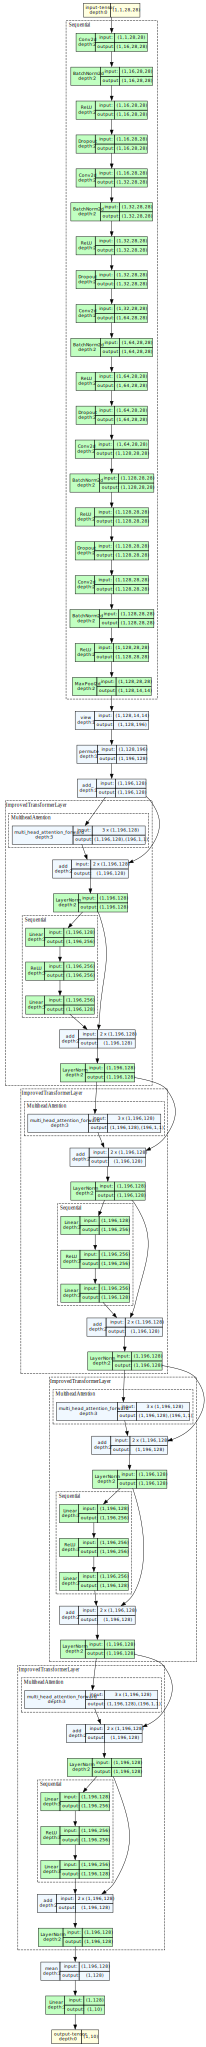

In [14]:
images, labels = next(iter(test_loader))

# Move the data to the appropriate device (GPU or CPU)
images = images.to(device)

# Visualize the model using torchview
graph = draw_graph(model, input_size=(1, 1, 28, 28), device=device, expand_nested=True, save_graph = True)

# Save the graph to a file
graph.visual_graph

In [15]:
torch.onnx.export(model, images, "cct_model_fashionmnist.onnx", input_names=["input"], output_names=["output"], export_params=True)

d:\anaconda\envs\ml_gpu_env\lib\site-packages\torch\onnx\symbolic_helper.py:325: UserWarning: Type cannot be inferred, which might cause exported graph to produce incorrect results.
  warnings.warn("Type cannot be inferred, which might cause exported graph to produce incorrect results.")


In [16]:
# Model must be on the device (GPU or CPU)
model.to(device)

# Show the model summary
summary(model, input_size=(1, 28, 28))  # Input size for a grayscale image (like FashionMNIST)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
       BatchNorm2d-6           [-1, 32, 28, 28]              64
              ReLU-7           [-1, 32, 28, 28]               0
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          18,496
      BatchNorm2d-10           [-1, 64, 28, 28]             128
             ReLU-11           [-1, 64, 28, 28]               0
          Dropout-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

### Model Training

In [17]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Initialize model, loss function and optimizer
model = CCT(input_channels=1, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping and checkpointing parameters
best_val_loss = float('inf')  # Initialize best validation loss as infinity
patience = 5  # Number of epochs with no improvement after which training will be stopped
early_stop_counter = 0  # Counter for early stopping
checkpoint_path = "best_model.pth"  # Path to save the best model

# Initialize lists to store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0  # For training accuracy
    
    # Progress bar with tqdm for training phase
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Update progress bar
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_accuracy = 100 * correct_train / total_train  # Training accuracy
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0  # For validation accuracy
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val  # Validation accuracy
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Print training and validation results for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {total_val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Early Stopping & Model Saving
    avg_val_loss = total_val_loss / len(val_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset early stopping counter if improvement
        print("Validation loss improved. Saving model weights...")
        torch.save(model.state_dict(), checkpoint_path)  # Save the best model
    else:
        early_stop_counter += 1  # Increment early stopping counter
    
    if early_stop_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs with no improvement.")
        break  # Stop training if no improvement for 'patience' epochs

# After training is complete, load the best model weights
print("Loading the best model weights from saved checkpoint...")
model.load_state_dict(torch.load(checkpoint_path))


Epoch [1/30], Training Loss: 0.7055, Training Accuracy: 73.79%, Validation Loss: 0.4297, Validation Accuracy: 84.00%
Validation loss improved. Saving model weights...


Epoch [2/30], Training Loss: 0.4081, Training Accuracy: 85.14%, Validation Loss: 0.3277, Validation Accuracy: 88.37%
Validation loss improved. Saving model weights...


Epoch [3/30], Training Loss: 0.3368, Training Accuracy: 87.73%, Validation Loss: 0.3241, Validation Accuracy: 88.43%
Validation loss improved. Saving model weights...


Epoch [4/30], Training Loss: 0.3003, Training Accuracy: 89.16%, Validation Loss: 0.2833, Validation Accuracy: 89.67%
Validation loss improved. Saving model weights...


Epoch [5/30], Training Loss: 0.2779, Training Accuracy: 90.09%, Validation Loss: 0.2863, Validation Accuracy: 89.75%


Epoch [6/30], Training Loss: 0.2648, Training Accuracy: 90.29%, Validation Loss: 0.2665, Validation Accuracy: 90.43%
Validation loss improved. Saving model weights...


Epoch [7/30], Training Loss: 0.2524, Training Accuracy: 90.81%, Validation Loss: 0.2323, Validation Accuracy: 91.98%
Validation loss improved. Saving model weights...


Epoch [8/30], Training Loss: 0.2419, Training Accuracy: 91.30%, Validation Loss: 0.2748, Validation Accuracy: 90.58%


Epoch [9/30], Training Loss: 0.2330, Training Accuracy: 91.49%, Validation Loss: 0.2202, Validation Accuracy: 92.45%
Validation loss improved. Saving model weights...


Epoch [10/30], Training Loss: 0.2281, Training Accuracy: 91.79%, Validation Loss: 0.2334, Validation Accuracy: 91.55%


Epoch [11/30], Training Loss: 0.2188, Training Accuracy: 92.01%, Validation Loss: 0.2346, Validation Accuracy: 91.45%


Epoch [12/30], Training Loss: 0.2144, Training Accuracy: 92.23%, Validation Loss: 0.2186, Validation Accuracy: 92.45%
Validation loss improved. Saving model weights...


Epoch [13/30], Training Loss: 0.2089, Training Accuracy: 92.41%, Validation Loss: 0.2124, Validation Accuracy: 92.37%
Validation loss improved. Saving model weights...


Epoch [14/30], Training Loss: 0.2072, Training Accuracy: 92.55%, Validation Loss: 0.2193, Validation Accuracy: 92.53%


Epoch [15/30], Training Loss: 0.2007, Training Accuracy: 92.69%, Validation Loss: 0.2101, Validation Accuracy: 92.67%
Validation loss improved. Saving model weights...


Epoch [16/30], Training Loss: 0.1978, Training Accuracy: 92.84%, Validation Loss: 0.2043, Validation Accuracy: 92.82%
Validation loss improved. Saving model weights...


Epoch [17/30], Training Loss: 0.1923, Training Accuracy: 93.04%, Validation Loss: 0.2115, Validation Accuracy: 92.67%


Epoch [18/30], Training Loss: 0.1900, Training Accuracy: 93.15%, Validation Loss: 0.2148, Validation Accuracy: 92.60%


Epoch [19/30], Training Loss: 0.1877, Training Accuracy: 93.09%, Validation Loss: 0.2119, Validation Accuracy: 92.87%


Epoch [20/30], Training Loss: 0.1871, Training Accuracy: 93.16%, Validation Loss: 0.2089, Validation Accuracy: 92.82%


Epoch [21/30], Training Loss: 0.1842, Training Accuracy: 93.37%, Validation Loss: 0.1898, Validation Accuracy: 93.43%
Validation loss improved. Saving model weights...


Epoch [22/30], Training Loss: 0.1772, Training Accuracy: 93.59%, Validation Loss: 0.1932, Validation Accuracy: 93.62%


Epoch [23/30], Training Loss: 0.1774, Training Accuracy: 93.61%, Validation Loss: 0.2015, Validation Accuracy: 93.05%


Epoch [24/30], Training Loss: 0.1741, Training Accuracy: 93.61%, Validation Loss: 0.2003, Validation Accuracy: 93.10%


Epoch [25/30], Training Loss: 0.1737, Training Accuracy: 93.66%, Validation Loss: 0.1965, Validation Accuracy: 93.23%


Epoch [26/30], Training Loss: 0.1705, Training Accuracy: 93.73%, Validation Loss: 0.2002, Validation Accuracy: 93.05%
Early stopping triggered after 5 epochs with no improvement.
Loading the best model weights from saved checkpoint...


<All keys matched successfully>

##### **Explanation**:
- **Training Loop**: We loop through the dataset, perform a forward pass, compute the loss, and then perform backpropagation to update model weights.
- **Loss**: We use CrossEntropyLoss as it’s suitable for classification problems.
- **Optimizer**: We use Adam optimizer for its efficiency in convergence.

##### Accuracy and Loss Plot

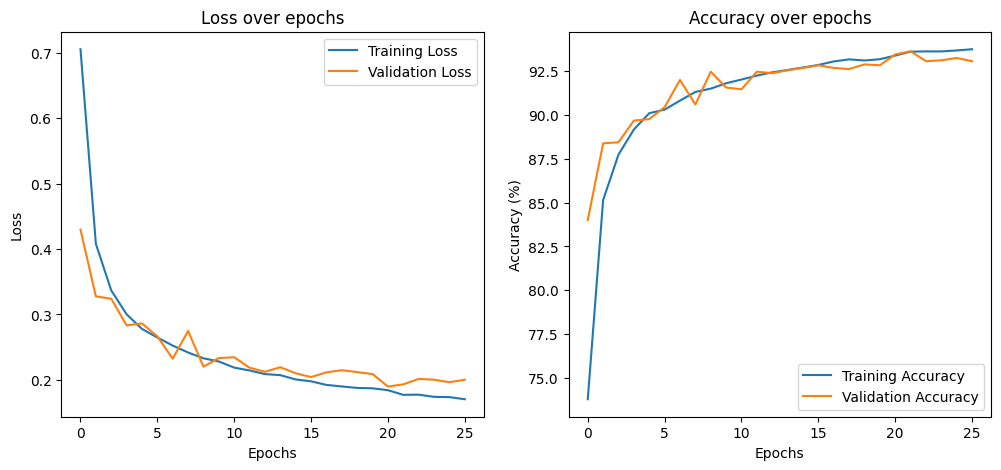

In [18]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Show the plots
plt.show()

### Model Evaluation

For a classification problem like FashionMNIST, you can evaluate the model using several metrics to measure its performance. Below are some common evaluation metrics and how to implement them in PyTorch.

### 1. **Accuracy**
   - **Definition**: Accuracy is the ratio of the number of correct predictions to the total number of predictions made.
   - **Implementation**: This metric is typically the primary one for classification tasks and is already computed during the training loop in your code (`train_accuracy` and `val_accuracy`).
   - **Formula**: 
     $$
     \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}} \times 100
     $$
   - **Usage**: Use the training and validation accuracies from your loop, but also you can calculate it on the **test set**.

### 2. **Precision**
   - **Definition**: Precision measures how many of the predicted positive labels are actually correct. It’s useful when the cost of false positives is high.
   - **Formula**: 
     $$
     \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
     $$

### 3. **Recall (Sensitivity or True Positive Rate)**
   - **Definition**: Recall measures how many actual positives the model correctly identified. It’s useful when the cost of false negatives is high.
   - **Formula**: 
     $$
     \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
     $$

### 4. **F1 Score**
   - **Definition**: The F1 Score is the harmonic mean of precision and recall, providing a balance between the two.
   - **Formula**: 
     $$
     F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     $$

### 5. **Confusion Matrix**
   - **Definition**: A confusion matrix provides insights into the types of errors the classifier makes. It shows the number of true positives, false positives, true negatives, and false negatives.
   - **Usage**: It helps to see where the model is confusing certain classes.

### 6. **Classification Report**
   - **Definition**: The classification report gives a detailed breakdown of precision, recall, F1 score, and support for each class.
   - **Implementation**: In PyTorch, you can use `sklearn.metrics.classification_report`.

---

### Key Components:
1. **`accuracy_score`**: Calculates the accuracy of the test set.
2. **`precision_score`, `recall_score`, `f1_score`**:
   - These metrics are calculated both for each class and averaged (macro-average).
   - You can change `average='macro'` to `average='micro'` or `average='weighted'` depending on your use case.
3. **`classification_report`**: Provides precision, recall, and F1 score for each class in the dataset.
4. **Confusion Matrix**:
   - The confusion matrix is visualized using `seaborn` to show the number of correct and incorrect predictions per class.

---

### Summary of Evaluation Metrics:
- **Accuracy**: Good for general performance measurement but can be misleading if the data is imbalanced.
- **Precision**: Focuses on how accurate the positive predictions are.
- **Recall**: Focuses on capturing all relevant positive samples.
- **F1 Score**: Balances between precision and recall.
- **Confusion Matrix**: Helps to visualize where the model makes mistakes by class.

These metrics give a comprehensive evaluation of how your model performs on classification tasks like FashionMNIST.

In [19]:
# Retrieve the class names dynamically
class_names = test_dataset.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [20]:
model = CCT(input_channels=1, num_classes=10).to(device)
# Load the saved model weights
checkpoint_path = "best_model.pth"
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [21]:
# Test the model on unseen test data
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy on unseen data: {test_accuracy:.2f}%')


Test Accuracy on unseen data: 93.07%


In [22]:
# Set the model to evaluation mode
model.eval()

# Evaluate model on test set
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for faster computations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())  # Convert tensor to numpy
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays for sklearn metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1 Score (macro-average and per-class)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 93.07%
Precision: 0.9317
Recall: 0.9307
F1 Score: 0.9310


In [23]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds,target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.89      0.87      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.91      0.91      1000
       Dress       0.93      0.91      0.92      1000
        Coat       0.89      0.90      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.78      0.81      0.79      1000
     Sneaker       0.95      0.99      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



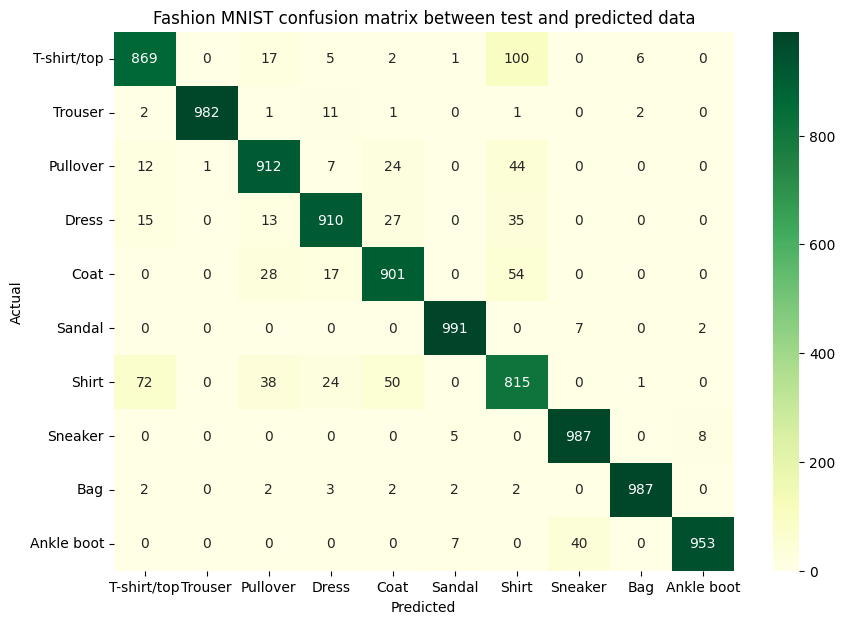

In [24]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fashion MNIST confusion matrix between test and predicted data")
plt.show()

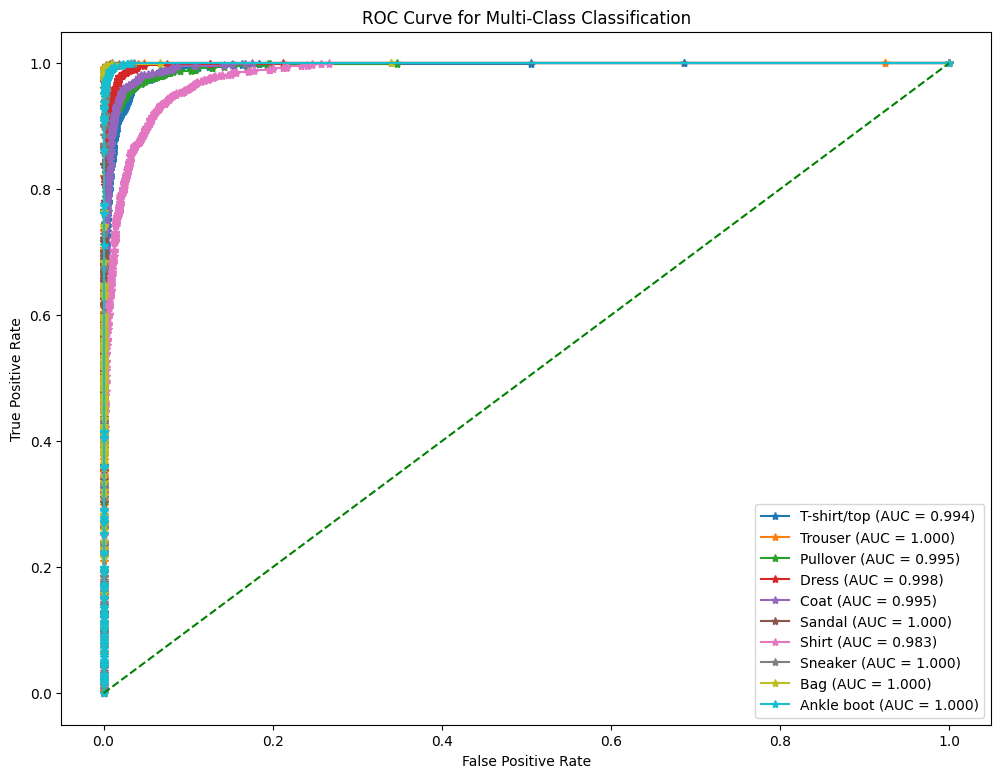

In [25]:
# Number of classes in the FashionMNIST dataset
n_classes = len(class_names)

# Ensure the model is in evaluation mode
model.eval()

# Step 1: Collect model outputs (probabilities) and true labels
all_preds_proba = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for faster computations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Get predicted probabilities instead of class labels
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        all_preds_proba.extend(probabilities.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for further processing
all_preds_proba = np.array(all_preds_proba)  # Shape: [num_samples, num_classes]
all_labels = np.array(all_labels)  # Shape: [num_samples]

# Step 2: Binarize the labels for multi-class ROC
all_labels_bin = label_binarize(all_labels, classes=range(n_classes))  # Shape: [num_samples, num_classes]

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()  # False Positive Rates
tpr = dict()  # True Positive Rates
roc_auc = dict()  # AUC scores

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot ROC curves for each class
plt.figure(figsize=(12, 9))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], marker='*', label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

# Plot the chance line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()


The **ROC Curve** (Receiver Operating Characteristic Curve) and **AUC** (Area Under the Curve) are powerful tools for evaluating the performance of a classification model, especially in multi-class settings like the FashionMNIST dataset.

### Explanation of ROC Curve:

1. **ROC Curve Overview**:
   - The ROC curve is a plot that shows the performance of a classification model by comparing the **True Positive Rate (TPR)** (also known as sensitivity or recall) against the **False Positive Rate (FPR)** for various threshold values.
   - **TPR** (y-axis) is the proportion of actual positives (e.g., a "T-shirt") that are correctly predicted by the model.
   - **FPR** (x-axis) is the proportion of actual negatives (e.g., "not a T-shirt") that are incorrectly predicted as positives (i.e., false positives).

2. **Multi-class ROC**:
   - For multi-class problems like FashionMNIST (10 classes), we compute one ROC curve per class. Each class is treated as a "one-vs-all" classification problem. For example, for the "T-shirt" class, it considers whether the model correctly identifies "T-shirts" (positive class) and whether it confuses other classes as "T-shirts" (negative class).
   - In the attached plot, each curve represents the ROC curve for one of the 10 FashionMNIST classes (e.g., T-shirt, Trouser, Dress, etc.).

3. **Diagonal Reference Line**:
   - The green diagonal dashed line represents a **random classifier** (i.e., if the model were just guessing, it would produce this diagonal). A model performing better than random should have its ROC curve above this line.

4. **Interpretation of the ROC Curves**:
   - In the provided plot, all curves are well above the diagonal line, indicating that the model performs significantly better than random guessing.
   - Each curve is relatively close to the top-left corner, which means the model has a high **True Positive Rate** and a low **False Positive Rate**, which indicates good performance.

### Explanation of AUC Score:

1. **AUC Overview**:
   - The **AUC (Area Under the Curve)** is a single number that summarizes the overall performance of the model.
   - An AUC of 1.0 represents a **perfect classifier**. The closer the AUC is to 1, the better the model is at distinguishing between the classes.
   - An AUC of 0.5 represents a **random classifier** (essentially, the model is guessing).

2. **Interpretation of AUC Scores**:
   - In your ROC plot legend, you can see the **AUC scores** for each class, such as:
     - **T-shirt/top (AUC = 0.994)**
     - **Trouser (AUC = 1.000)**
     - **Sandal (AUC = 1.000)**
     - **Shirt (AUC = 0.983)**, etc.
   - **High AUC scores** (close to 1) indicate that the model is very good at distinguishing the specific class from all others. For example:
     - The model has **perfect performance** on some classes like **Trouser, Sandal, Sneaker, Bag, and Ankle boot**, where the AUC is exactly **1.000**.
     - For the other classes, like **T-shirt/top (AUC = 0.994)** and **Shirt (AUC = 0.983)**, the AUC is very close to 1, showing strong classification performance with minor room for improvement.
   - **Shirt** has the lowest AUC of **0.983**, which means the model finds it slightly harder to distinguish "Shirts" from other clothing categories, but it's still performing well.

### Overall Summary:
- The ROC curve visually demonstrates the model's ability to balance true positives and false positives across different classification thresholds.
- The AUC score quantifies the overall performance. With AUC scores close to or equal to 1 for all classes, the model is performing exceptionally well on FashionMNIST.
- The curves clustered near the top-left corner confirm that the model is achieving high accuracy with few false positives.

In [26]:
# After you have collected the predictions and actual labels
all_preds = np.array(all_preds)  # Your predicted labels
all_labels = np.array(all_labels)  # Your actual labels

# Limit to the first 10,000 examples
all_preds = all_preds[:10000]
all_labels = all_labels[:10000]

# Find correct and incorrect predictions
correct = np.nonzero(all_preds == all_labels)[0]
incorrect = np.nonzero(all_preds != all_labels)[0]

# Print the number of correct and incorrect predictions
print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])


Correct predicted classes: 9307
Incorrect predicted classes: 693


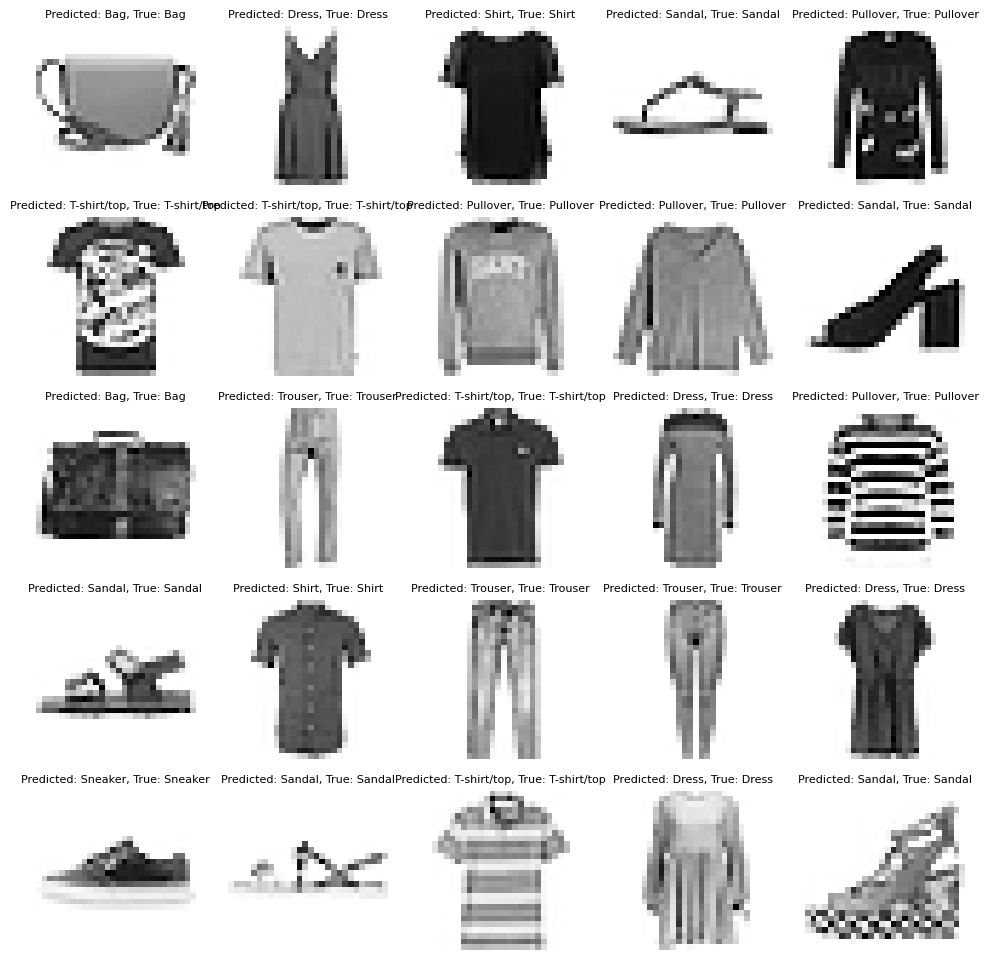

In [27]:
# Create a random sample of 25 correct predictions
random_indices = np.random.choice(correct, 25, replace=False)

# Convert images back from tensor to NumPy array and unnormalize them
test_images = []
for i in random_indices:
    image_tensor = test_loader.dataset[i][0]  # Get the image from test_loader (first element is image, second is label)
    image_np = image_tensor.squeeze().cpu().numpy()  # Convert to NumPy array and remove channel dimension (1, 28, 28) -> (28, 28)
    test_images.append(image_np)

# Plotting the images with predictions and true labels
plt.figure(figsize=(12, 12))
for i, correct_index in enumerate(random_indices):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i], cmap='Greys', interpolation='none')  # Show the image
    plt.title(f"Predicted: {class_names[all_preds[correct_index]]}, True: {class_names[all_labels[correct_index]]}", fontsize=8,ha='center', wrap=True)  # Use class names
    plt.axis('off')
plt.show()